Začínam tréning navigačného agenta s neurónovou sieťou.
Veľkost sveta: 10x10, cieľ: [9, 9], max. krokov: 50
Vytvorená populácia s 500 jedincami
Začínam evolúciu - 200 generácií...
gen	nevals	priemer	minimum	maximum	std_odchylka
0  	500   	17.71  	1      	203.333	28.4004     
1  	396   	27.7873	1      	203.333	35.4362     
2  	388   	38.786 	1      	206.333	43.3884     
3  	374   	44.9753	1.33333	206.333	49.879      
4  	353   	52.8967	1      	206.333	55.8601     
5  	380   	57.9367	2      	206.333	64.1311     
6  	363   	69.8713	1.66667	206.333	74.2744     
7  	386   	74.3053	1.33333	206.667	79.4231     
8  	365   	104.791	1      	206.333	86.1241     
9  	377   	132.718	2      	206.333	85.7797     
10 	384   	146.681	1.66667	207.333	82.02       
11 	385   	158.907	4      	207.333	74.9607     
12 	364   	157.607	4.33333	207.667	76.4718     
13 	379   	158.526	8      	207.667	75.0304     
14 	384   	167.033	4      	207.667	70.4987     
15 	373   	168.765	3.66667	207.667	68.8735     
16 	

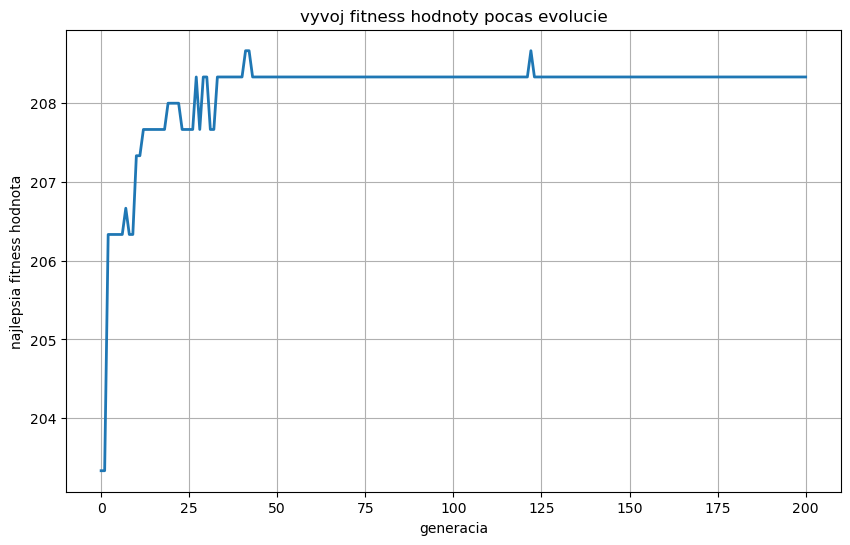


Vizualizujem správanie najlepšieho agenta...


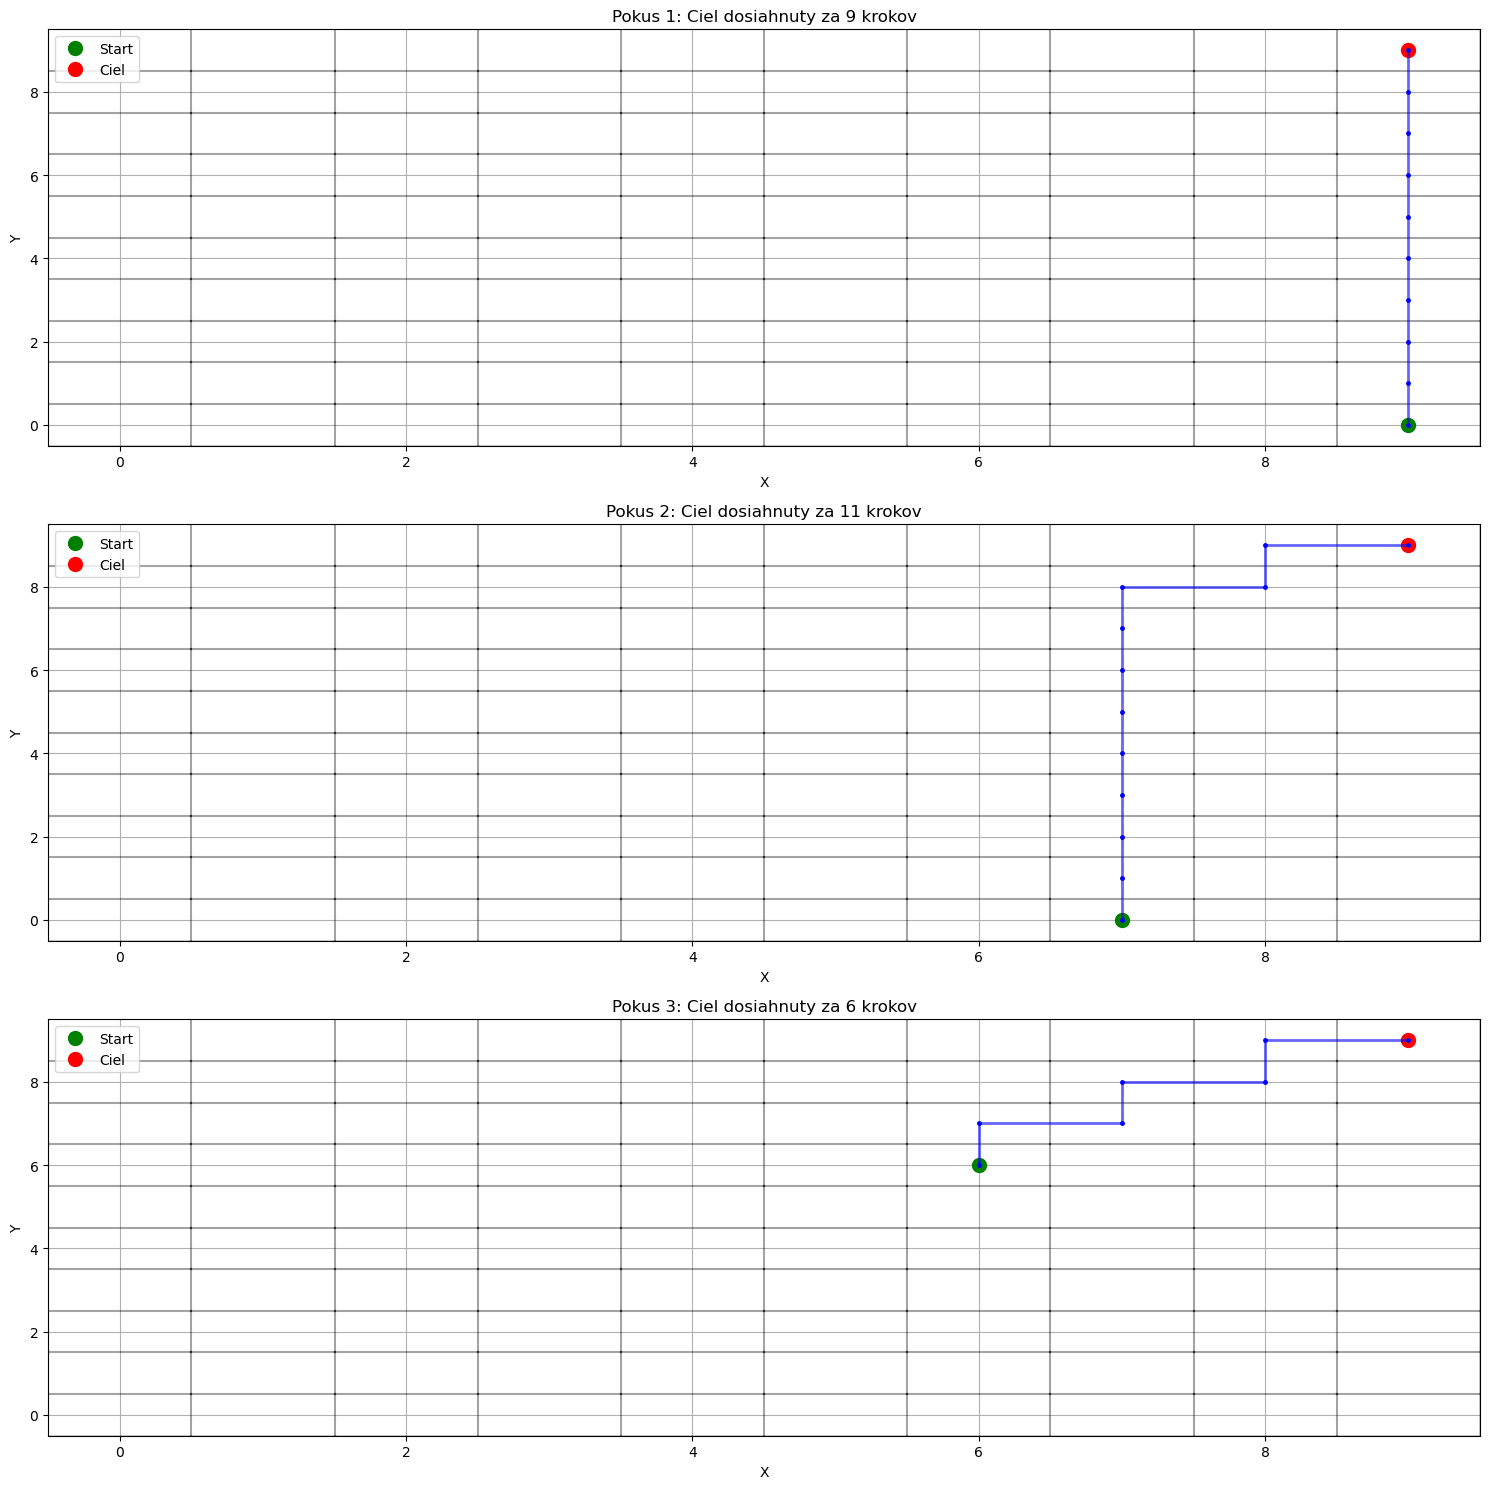

Hotovo! Agent úspešne natrénovaný


In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms

# ======================================================================================
# nastavenia prostredia
# ======================================================================================
WORLD_SIZE = 10         # velkost stvorcovej mriezky sveta (10x10)
TARGET_POSITION = [9, 9]   # cielova pozicia je v pravom dolnom rohu
MAX_STEPS = 50            # maximalny pocet krokov povolenych na jedno kolo

# ======================================================================================
# nastavenia neuronovej siete
# ======================================================================================
NUM_INPUTS = 5          # 5 senzorovych vstupov (4 smery k cielu + 1 rozsirena funkcia)
NUM_NEURONS = 10        # 10 neuronov v skrytej vrstve
NUM_OUTPUTS = 4         # 4 vystupy (hore, dole, vlavo, vpravo)

# ======================================================================================
# vypocet celkoveho poctu vah v neuronovej sieti
# ======================================================================================
GENOME_SIZE = (NUM_INPUTS * NUM_NEURONS + NUM_NEURONS + NUM_NEURONS * NUM_OUTPUTS + NUM_OUTPUTS)

# ======================================================================================
# nastavenia genetickeho algoritmu
# ======================================================================================
POPULATION_SIZE = 500     # pocet jedincov v populacii
MUTATION_PROB = 0.2       # pravdepodobnost mutacie jedinca
GENE_MUTATION_PROB = 0.1  # pravdepodobnost mutacie kazdeho genu
CROSSOVER_PROB = 0.7      # pravdepodobnost krizenia dvoch jedincov
TOURNAMENT_SIZE = 5       # velkost turnajoveho vyberu
NUM_ELITE_INDIVIDUALS = 20  # pocet najlepsich jedincov, ktori sa zachovaju nezmeneni
MAX_GENERATIONS = 30     # maximalny pocet generacii evolucie
NUM_GAME_ROUNDS = 3       # pocet hernych kol na vyhodnotenie jedinca

# ======================================================================================
# vymazanie existujucich tried deap 
# ======================================================================================
if "FitnessMax" in creator.__dict__:
    del creator.FitnessMax
if "Individual" in creator.__dict__:
    del creator.Individual

# ======================================================================================
# vytvorenie zakladnych tried pre geneticky algoritmus
# ======================================================================================
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

# ======================================================================================
# vlastna senzorickah funkcia
# ======================================================================================
def sense_environment(position, target):
    # senzoricka funkcia, ktorou agenti vnimaju prostredie
    x, y = position
    target_x, target_y = target

    # vzdialenost k cielu v kazdom smere (normalizovana, blizsie = vyssia hodnota)
    distance_up = max(0, target_y - y) / WORLD_SIZE
    distance_down = max(0, y - target_y) / WORLD_SIZE
    distance_left = max(0, x - target_x) / WORLD_SIZE
    distance_right = max(0, target_x - x) / WORLD_SIZE

    # normalizovana manhattan vzdialenost k cielu (blizsie = vyssia hodnota)
    manhattan_distance = (abs(x - target_x) + abs(y - target_y)) / (2 * WORLD_SIZE)
    #print(f"manhattan_distance: {manhattan_distance}")
    target_proximity = 1 - manhattan_distance  # inverzia: blizsie = vyssia hodnota

    return [
        1 - distance_up,    # blizsie = vyssia hodnota
        1 - distance_down,
        1 - distance_left,
        1 - distance_right,
        target_proximity
    ]
# ======================================================================================
# vypocet neuronovej siete
# ======================================================================================
def nn_function(inp, wei):
    # funkcia pre vypocet vystupu neuronovej siete na zaklade vstupov a vah
    # extrakcia vah z genomu pre jednotlive vrstvy
    input_weights = np.array(wei[:NUM_INPUTS * NUM_NEURONS])
    input_weights = input_weights.reshape(NUM_INPUTS, NUM_NEURONS)
    
    biases = np.array(wei[NUM_INPUTS * NUM_NEURONS:
                                 NUM_INPUTS * NUM_NEURONS + NUM_NEURONS])
    
    output_weights = np.array(wei[NUM_INPUTS * NUM_NEURONS + NUM_NEURONS:-NUM_OUTPUTS])
    output_weights = output_weights.reshape(NUM_NEURONS, NUM_OUTPUTS)
    
    output_biases = np.array(wei[-NUM_OUTPUTS:])

    # vypocet skrytej vrstvy s relu aktivaciou
    layer = np.dot(inp, input_weights) + biases
    layer = np.maximum(0, layer)  # relu aktivacia

    # vypocet vystupnej vrstvy
    output = np.dot(layer, output_weights) + output_biases

    # softmax pre ziskanie rozdelenia pravdepodobnosti
    exp_output = np.exp(output - np.max(output))
    probabilities = exp_output / exp_output.sum()

    return probabilities

# ======================================================================================
# navigacia agenta
# ======================================================================================
def nn_navigate_me(me, inp):
    # funkcia, ktora pre agenta me a jeho senzoricke vstupy inp vykona vypocet
    # jeho pohybu na zaklade jeho vnutorneho genomu
    action_probabilities = nn_function(inp, me)
    return np.argmax(action_probabilities)

# ======================================================================================
# simulacia jedneho kola hry
# ======================================================================================
def simulate_game_round(agent_genome, start_position=None):
    # simuluje jedno herne kolo pre daneho agenta
    if start_position is None:
        position = [random.randint(0, WORLD_SIZE-1), random.randint(0, WORLD_SIZE-1)]
    else:
        position = start_position.copy()

    # pokial je nahodna startovacia pozicia rovna ako ciel, vygeneruj novu
    if position == TARGET_POSITION:
        return simulate_game_round(agent_genome)

    step_count = 0
    visited_positions = []
    target_reached = False

    while step_count < MAX_STEPS and not target_reached:
        # ziskanie senzorickych vstupov
        input_values = sense_environment(position, TARGET_POSITION)
        
        # vypocet pohybu pomocou neuronovej siete
        selected_move = nn_navigate_me(agent_genome, input_values)
        
        visited_positions.append(tuple(position))
        
        new_position = position.copy()
        
        # vykonanie pohybu
        if selected_move == 0 and position[1] < WORLD_SIZE-1:    # hore
            new_position[1] += 1
        elif selected_move == 1 and position[1] > 0:             # dole
            new_position[1] -= 1
        elif selected_move == 2 and position[0] > 0:             # vlavo
            new_position[0] -= 1
        elif selected_move == 3 and position[0] < WORLD_SIZE-1:  # vpravo
            new_position[0] += 1
        
        position = new_position
        
        if position == TARGET_POSITION:
            target_reached = True
        
        step_count += 1
        
        # detekcia zaseknutia - penalizacia za opakovane navstevovanie rovnakych miest
        if visited_positions.count(tuple(position)) > 2:
            break

    # vypocet skore
    if target_reached:
        base_score = MAX_STEPS * 2
        speed_bonus = MAX_STEPS - step_count
        score = base_score + speed_bonus
    else:
        # ak ciel nebol dosiahnuty, skore sa pocita ako umerne vzdialenosti k cielu
        distance_to_target = abs(position[0] - TARGET_POSITION[0]) + abs(position[1] - TARGET_POSITION[1])
        max_distance = WORLD_SIZE * 2
        score = max(0, max_distance - distance_to_target)
        
        # penalizacia za pohyb v kruhu
        loop_penalty = sum(visited_positions.count(p) - 1 for p in set(visited_positions))
        score = max(1, score - loop_penalty)

    return score, step_count, target_reached

# ======================================================================================
# fitness funkcia
# ======================================================================================
def evaluate_individual(individual):
    total_score = 0
    target_reach_count = 0
    
    for _ in range(NUM_GAME_ROUNDS):
        # generovanie nahodnej startovnej pozicie (nie cielovej)
        start_position = [random.randint(0, WORLD_SIZE-1), random.randint(0, WORLD_SIZE-1)]
        while start_position == TARGET_POSITION:
            start_position = [random.randint(0, WORLD_SIZE-1), random.randint(0, WORLD_SIZE-1)]
        
        # simulacia jedneho kola
        score, steps, target_reached = simulate_game_round(individual, start_position)
        
        total_score += score
        if target_reached:
            target_reach_count += 1
    
    # vypocet priemerneho skore a bonusu za dosiahnutie ciela
    avg_score = total_score / NUM_GAME_ROUNDS
    final_fitness = avg_score + (target_reach_count * 20)  # bonus za dosiahnutie ciela
    
    return final_fitness,

# ======================================================================================
# funkcia na vypocet fitness hodnot pre viac jedincov
# ======================================================================================
def handle_mes_fitnesses(mes):
    results = []
    
    for i, individual in enumerate(mes):
        # generovanie nahodnej startovnej pozicie (nie cielovej)
        start_position = [random.randint(0, WORLD_SIZE-1), random.randint(0, WORLD_SIZE-1)]
        while start_position == TARGET_POSITION:
            start_position = [random.randint(0, WORLD_SIZE-1), random.randint(0, WORLD_SIZE-1)]
        
        # simulacia jedneho kola
        score, steps, target_reached = simulate_game_round(individual, start_position)
        
        # vypis vysledkov pre kazdeho jedinca
        print(f"Jedinec {i+1}: Skóre={score:.2f}, Kroky={steps}, Cieľ dosiahnutý={target_reached}")
        
        results.append((individual, score))
    
    print("=" * 50)
    print("Vystup handle_mes_fitnesses (fitnessy najlepsich jedincov)")
    print("=" * 50)
    print(f"\nPriemer fitness: {np.mean([r[1] for r in results]):.2f}")
    print(f"Najlepšia fitness: {np.max([r[1] for r in results]):.2f}")
    print(f"Najhoršia fitness: {np.min([r[1] for r in results]):.2f}")
    print("=" * 50)
    
    return results

# ======================================================================================
# vizualizacia najlepsieho agenta
# ======================================================================================
def display_best_agent(agent_genome, num_attempts=3):
    # vizualizuje spravanie najlepsieho agenta v mriezkovom svete
    plt.figure(figsize=(15, 5*num_attempts))

    for attempt in range(num_attempts):
        start_position = [random.randint(0, WORLD_SIZE-1), random.randint(0, WORLD_SIZE-1)]
        while start_position == TARGET_POSITION:
            start_position = [random.randint(0, WORLD_SIZE-1), random.randint(0, WORLD_SIZE-1)]
        
        position = start_position.copy()
        path = [position.copy()]
        step_count = 0
        target_reached = False
        
        while step_count < MAX_STEPS and not target_reached:
            input_values = sense_environment(position, TARGET_POSITION)
            selected_move = nn_navigate_me(agent_genome, input_values)
            
            new_position = position.copy()
            if selected_move == 0 and position[1] < WORLD_SIZE-1:
                new_position[1] += 1
            elif selected_move == 1 and position[1] > 0:
                new_position[1] -= 1
            elif selected_move == 2 and position[0] > 0:
                new_position[0] -= 1
            elif selected_move == 3 and position[0] < WORLD_SIZE-1:
                new_position[0] += 1
            
            position = new_position
                
            path.append(position.copy())
            
            if position == TARGET_POSITION:
                target_reached = True
                
            step_count += 1
        
        plt.subplot(num_attempts, 1, attempt+1)
        plt.grid(True)
        plt.xlim(-0.5, WORLD_SIZE-0.5)
        plt.ylim(-0.5, WORLD_SIZE-0.5)
        
        for i in range(WORLD_SIZE):
            for j in range(WORLD_SIZE):
                plt.plot([i-0.5, i+0.5], [j-0.5, j-0.5], 'k-', alpha=0.2)
                plt.plot([i-0.5, i-0.5], [j-0.5, j+0.5], 'k-', alpha=0.2)
                plt.plot([i+0.5, i+0.5], [j-0.5, j+0.5], 'k-', alpha=0.2)
                plt.plot([i-0.5, i+0.5], [j+0.5, j+0.5], 'k-', alpha=0.2)
        
        plt.plot(start_position[0], start_position[1], 'go', markersize=10, label='Start')
        plt.plot(TARGET_POSITION[0], TARGET_POSITION[1], 'ro', markersize=10, label='Ciel')
        
        path_x = [point[0] for point in path]
        path_y = [point[1] for point in path]
        plt.plot(path_x, path_y, 'b-', linewidth=2, alpha=0.6)
        plt.plot(path_x, path_y, 'b.', markersize=5)
        
        plt.title(f'Pokus {attempt+1}: {"Ciel dosiahnuty" if target_reached else "Neuspesny"} za {len(path)-1} krokov')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.legend()

    plt.tight_layout()
    plt.show()

# ======================================================================================
# hlavna funkcia
# ======================================================================================
if __name__ == "__main__":
    print("Začínam tréning navigačného agenta s neurónovou sieťou.")
    print(f"Veľkost sveta: {WORLD_SIZE}x{WORLD_SIZE}, cieľ: {TARGET_POSITION}, max. krokov: {MAX_STEPS}")
    
    # nastavenie parametrov evolucneho algoritmu
    toolbox = base.Toolbox()

    # inicializacia genomu s rovnomernym rozlozenim hodnot medzi -1 a 1
    toolbox.register("generate_gene", random.uniform, -1, 1)
    toolbox.register("individual", tools.initRepeat, creator.Individual, 
                     toolbox.generate_gene, n=GENOME_SIZE)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    
    # registracia operatorov genetickeho algoritmu
    toolbox.register("evaluate", evaluate_individual)
    toolbox.register("mate", tools.cxTwoPoint)  # dvojbodove krizenie
    toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.3, indpb=GENE_MUTATION_PROB)
    toolbox.register("select", tools.selTournament, tournsize=TOURNAMENT_SIZE)
    
    # inicializacia populacie
    population = toolbox.population(n=POPULATION_SIZE)
    print(f"Vytvorená populácia s {POPULATION_SIZE} jedincami")
    
    # halova slava (uchovava najlepsich jedincov)
    hof = tools.HallOfFame(NUM_ELITE_INDIVIDUALS)
    
    # statistiky
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("priemer", np.mean)
    stats.register("minimum", np.min)
    stats.register("maximum", np.max)
    stats.register("std_odchylka", np.std)
    
    # vyuzitie vstavaneho algoritmu eaSimple z DEAP kniznice
    print(f"Začínam evolúciu - {MAX_GENERATIONS} generácií...")
    final_population, logbook = algorithms.eaSimple(
        population, 
        toolbox, 
        cxpb=CROSSOVER_PROB,     # pravdepodobnost krizenia
        mutpb=MUTATION_PROB,     # pravdepodobnost mutacie
        ngen=MAX_GENERATIONS,    # pocet generacii
        stats=stats,
        halloffame=hof,
        verbose=True
    )
    
    # ziskanie najlepsieho jedinca
    best_individual = hof[0]
    
    print("\n=== Najlepší jedinec ===")
    print(f"Fitness hodnota: {best_individual.fitness.values[0]:.2f}")
    print(f"Tréning dokonceny po {MAX_GENERATIONS} generáciach.")
    print("=" * 50)
    print(f"Fitnessy najlepších individuálov")
    handle_mes_fitnesses(hof) # volanie handle_mes_fitnesses aby sme vedeli ako su na tom
    
    # zobrazenie vyvoja fitness hodnoty
    gen = logbook.select("gen")
    fit_max = logbook.select("maximum")
    
    plt.figure(figsize=(10, 6))
    plt.plot(gen, fit_max, linewidth=2)
    plt.xlabel('generacia')
    plt.ylabel('najlepsia fitness hodnota')
    plt.title('vyvoj fitness hodnoty pocas evolucie')
    plt.grid(True)
    plt.show()
    
    print("\nVizualizujem správanie najlepšieho agenta...")
    display_best_agent(best_individual)
    
    print("Hotovo! Agent úspešne natrénovaný")